In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
act_data = pd.read_csv("./data/BERT_action_hand.csv")

# 행동을 설명하는 문장

In [3]:
act_data

,action,효능
0,명상,긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
1,산책,기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
2,등산,맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
3,샤워,혈액 순환을 촉진하여 피로를 해소하고 노폐물을 배출한다
4,수영,지구력과 근력을 향상시키고 숙면 및 체중관리에 도움이 된다
5,조깅,심폐기능을 강화하며 체중관리 및 스트레스 해소에 도움이 된다
6,자전거 타기,심폐기능 및 관절과 근력을 강화하며 스트레스를 해소한다
7,요가,유연성과 힘을 길러주고 자세를 교정하며 기분을 상쾌하게 한다
8,스트레칭,근육과 관절을 회복시키며 유연성과 혈액 순환을 돕는다
9,여행,행복감과 창의성을 높이고 고민을 잊게하며 기분 전환을 돕는다


# 차원을 설명하는 문장

In [4]:
dim_data = pd.read_csv("./data/BERT_dims.csv")

In [5]:
dim_data

,차원,설명
0,에너지,신체에 활력을 불어넣고 활동적이고 열정적이게 한다
1,회복,약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
2,순환,호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
3,정화,잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다


In [6]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
model = BertModel.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# BERT 모델을 사용해서 문장의 유사도 확인
현재 bert의 per-train의 output을 mean_pooling을 이용해서 sent vector로 바꾼 후 유사도를 계산하는 방식

In [7]:
def word_sim(sent1 , sent2):
    words = [sent1, sent2]
    tokens = {'input_ids' : [] , 'attention_mask' : []}

    
    for word in words:
        print(word)
        encoded = tokenizer.encode(word)
        #print(tokenizer.convert_ids_to_tokens(encoded))
        print('토큰의 수 : {} , 토큰화된 문장 {}'.format(len(encoded)-2,tokenizer.convert_ids_to_tokens(encoded)))
        new_tokens = tokenizer.encode_plus(word , max_length=128, truncation= True , padding='max_length' , return_tensors='pt')
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])
        
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
    
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state
    attention_mask = tokens['attention_mask']
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings,1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask
    mean_pooled = mean_pooled.detach().numpy()
    return cosine_similarity( mean_pooled[0].reshape(1,-1) , mean_pooled[1].reshape(1,-1))[0][0]

In [8]:
act_dim = pd.DataFrame(columns = ['에너지','회복','순환','정화'], index = act_data['action'])

## 수치화를 진행하면서 token의 수와 tokenize가 잘 되는 지 확인

In [9]:
e_est = []
e_sents = dim_data['설명'][0]
for idx in act_data.index:
    e_est.append(word_sim(e_sents,act_data['효능'][idx]))
    print('\n')
act_dim['에너지'] = e_est

신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
 긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '긴장', '##된', '몸을', '이완', '##시키고', '마음을', '안정', '##시켜', '편안하게', '한다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
 기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '기분을', '상쾌', '##하게', '하며', '혈액', '순환', '##에', '도움을', '주고', '창의', '##적이', '된다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
 맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '맑은', '공기', '##로', '몸을', '정화', '##시키고', '심장', '##과', '근육을', '튼튼', '##히', '한다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##

In [10]:
h_est = []
h_sents = dim_data['설명'][1]
for idx in act_data.index:
    h_est.append(word_sim(h_sents,act_data['효능'][idx]))
    print('\n')
act_dim['회복'] = h_est

약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
 긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '긴장', '##된', '몸을', '이완', '##시키고', '마음을', '안정', '##시켜', '편안하게', '한다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
 기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '기분을', '상쾌', '##하게', '하며', '혈액', '순환', '##에', '도움을', '주고', '창의', '##적이', '된다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
 맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '맑은', '공기', '##로', '몸을', '정화', '##시키고', '심장', '##과', '근육을', '튼튼', '##히', '한다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로

In [11]:
c_est = []
c_sents = dim_data['설명'][2]
for idx in act_data.index:
    c_est.append(word_sim(c_sents,act_data['효능'][idx]))
    print('\n')
act_dim['순환'] = c_est

호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
 긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '긴장', '##된', '몸을', '이완', '##시키고', '마음을', '안정', '##시켜', '편안하게', '한다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
 기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '기분을', '상쾌', '##하게', '하며', '혈액', '순환', '##에', '도움을', '주고', '창의', '##적이', '된다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
 맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '맑은', '공기', '##로', '몸을', '정화', '##시키고', '심장', '##과', '근육을', '튼튼', '##히', '한다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡',

In [12]:
p_est = []
p_sents = dim_data['설명'][3]
for idx in act_data.index:
    p_est.append(word_sim(p_sents,act_data['효능'][idx]))
    print('\n')
act_dim['정화'] = p_est

잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
 긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '긴장', '##된', '몸을', '이완', '##시키고', '마음을', '안정', '##시켜', '편안하게', '한다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
 기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '기분을', '상쾌', '##하게', '하며', '혈액', '순환', '##에', '도움을', '주고', '창의', '##적이', '된다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
 맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
토큰의 수 : 12 , 토큰화된 문장 ['[CLS]', '맑은', '공기', '##로', '몸을', '정화', '##시키고', '심장', '##과', '근육을', '튼튼', '##히', '한다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
 

# 행동 - 차원에 대한 유사도 확인

In [13]:
dim_data

,차원,설명
0,에너지,신체에 활력을 불어넣고 활동적이고 열정적이게 한다
1,회복,약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
2,순환,호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
3,정화,잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다


In [14]:
act_data

,action,효능
0,명상,긴장된 몸을 이완시키고 마음을 안정시켜 편안하게 한다
1,산책,기분을 상쾌하게 하며 혈액 순환에 도움을 주고 창의적이 된다
2,등산,맑은 공기로 몸을 정화시키고 심장과 근육을 튼튼히 한다
3,샤워,혈액 순환을 촉진하여 피로를 해소하고 노폐물을 배출한다
4,수영,지구력과 근력을 향상시키고 숙면 및 체중관리에 도움이 된다
5,조깅,심폐기능을 강화하며 체중관리 및 스트레스 해소에 도움이 된다
6,자전거 타기,심폐기능 및 관절과 근력을 강화하며 스트레스를 해소한다
7,요가,유연성과 힘을 길러주고 자세를 교정하며 기분을 상쾌하게 한다
8,스트레칭,근육과 관절을 회복시키며 유연성과 혈액 순환을 돕는다
9,여행,행복감과 창의성을 높이고 고민을 잊게하며 기분 전환을 돕는다


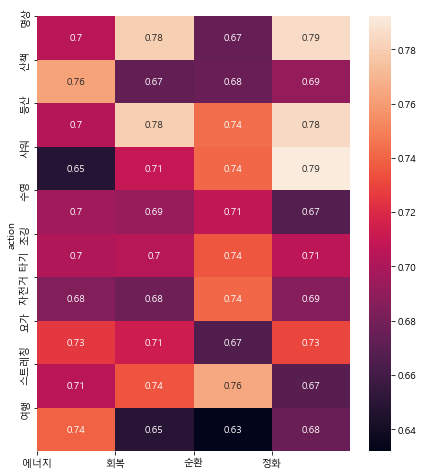

In [15]:
plt.rc('font', family='Malgun Gothic')

action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

fig = plt.figure(figsize=(7,8))
fig.set_facecolor('white')
#plt.title(f'{act_name}에서 단어들간의 유사도 확인')
sns.heatmap(act_dim,cbar=True,annot=True)
plt.xticks(np.arange(len(dim_list)),dim_list)
plt.yticks(np.arange(len(action_list)),action_list)
plt.show()


|action|설명(행동의 설명하는 문장을 보고 차원과 직접 매핑)|타당성|
|--|--|--|
|명상|(몸을 이완 -> 회복) , (마음을 안정 -> 정화)|타당|  
|산책|(순환 키워드/혈액 순환 , 순환) , (창의성/상쾌하게, 에너지,정화)|타당|
|등산|(정화 키워드, 정화) (몸을 튼튼,회복)|타당|
샤워|(노폐물 제거 , 정화) , (혈액순환 , 순환)|타당|
|수영|(근력 향샹/체중관리 , 회복)|애매|
|조깅|(심페기능 강화, 회복/순화) , (스트레스 해소, 정화)|애매|
|자전거 타기|(심폐기능, 순환/회복) , (관절/근력 강화, 회복) , (스트레스,정화)|애매|
|요가|(유연성/힘 상승, 회복) , (스트레스 해소/정화)|타당|
|스트레칭|(회복 키워드 , 회복), (혈액 순환 , 순환)|타당|
|여행|(행복감/창의성, 에너지) , (기분전환,정화/에너지)|타당|


In [16]:
act_dim

,에너지,회복,순환,정화
action,,,,
명상,0.704744,0.780029,0.674141,0.785436
산책,0.762434,0.672927,0.675206,0.691657
등산,0.703650,0.780104,0.743242,0.784192
샤워,0.647933,0.709434,0.741387,0.792117
수영,0.696124,0.692698,0.708138,0.667245
조깅,0.701238,0.704294,0.735655,0.705784
자전거 타기,0.684583,0.676447,0.741214,0.685959
요가,0.725525,0.713183,0.665409,0.730736
스트레칭,0.705116,0.735063,0.764200,0.668253


C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


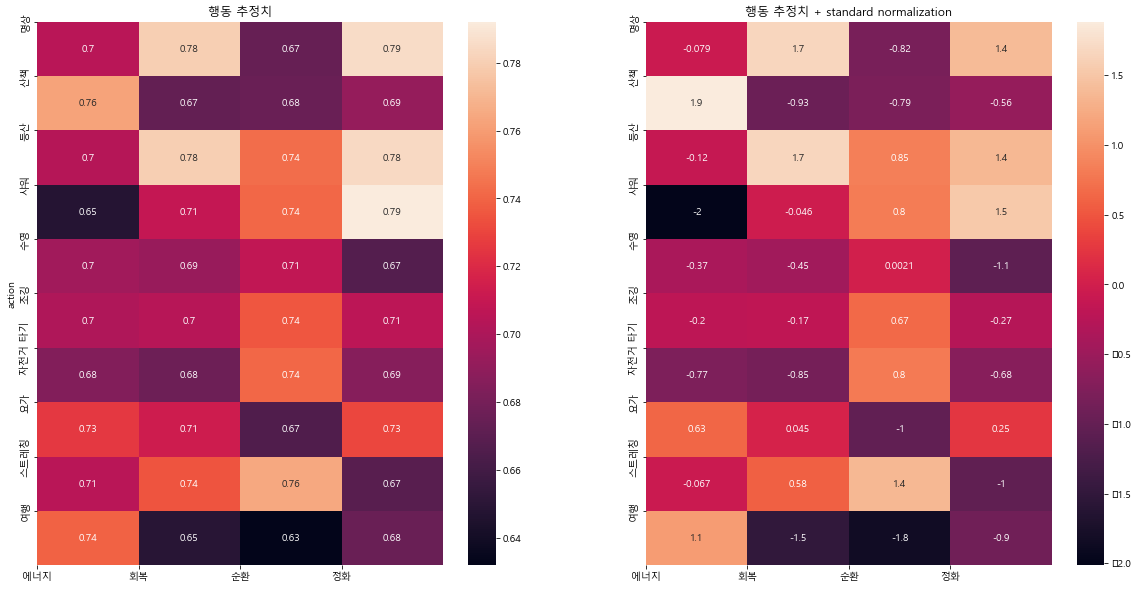

In [48]:
# 현재 행동 추정치를 standard normalization
from sklearn.preprocessing import StandardScaler

'''
std_est = []
for idx in act_dim.index:
    scaler = StandardScaler()
    act_est = np.array(act_dim.loc[idx]).reshape(-1,1)
    scaler.fit(act_est)
    std_act_est = scaler.transform(act_est).reshape(1,4).flatten()
    std_est.append(std_act_est)
'''

std_est = []
for col in act_dim.columns:
    s_scaler = StandardScaler()
    dim_ests = np.array(act_dim[col]).reshape(-1,1) 
    s_scaler.fit(dim_ests)
    std_dim_est = s_scaler.transform(dim_ests).flatten()
    std_est.append(std_dim_est)

std_est = np.array(std_est).T

plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(act_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(action_list)))
ax1.set_yticklabels(action_list)
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(std_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + standard normalization')
ax2.set_yticks(np.arange(0,len(action_list)))
ax2.set_yticklabels(action_list)
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

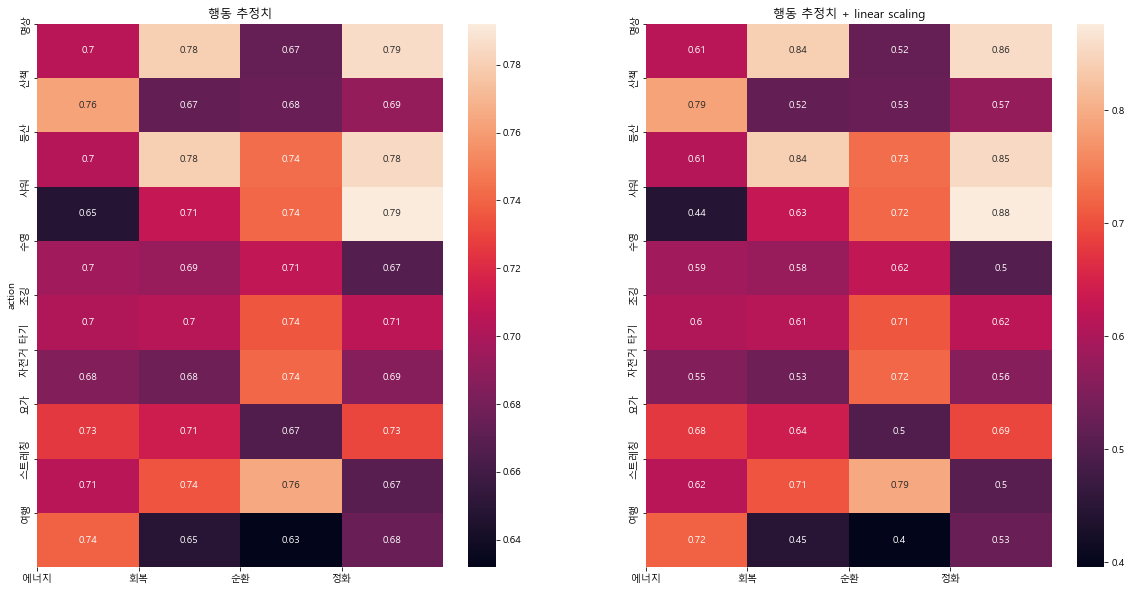

In [76]:
# 현재 행동 추정치를 linear scaling ( 2 * est - 0.7)
lin_est = []
for idx in act_dim.index:
    act_est = np.array(act_dim.loc[idx])
    std = np.std(act_est)
    nor_act_est =  (3 * act_est) - 1.5
    lin_est.append(nor_act_est)

plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(act_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(action_list)))
ax1.set_yticklabels(action_list)
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(lin_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + linear scaling')
ax2.set_yticks(np.arange(0,len(action_list)))
ax2.set_yticklabels(action_list)
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

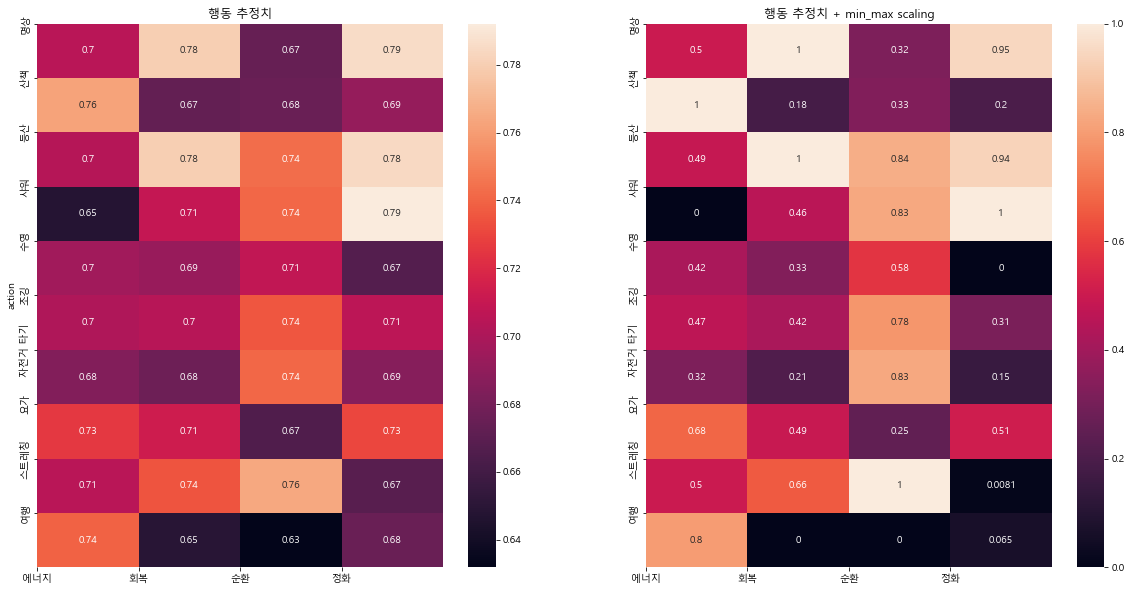

In [46]:
from sklearn.preprocessing import MinMaxScaler
'''
min_max_est = []
for idx in act_dim.index:
    scaler = MinMaxScaler()
    act_est = np.array(act_dim.loc[idx]).reshape(-1,1)
    scaler.fit(act_est)
    normal_act_est = scaler.transform(act_est).reshape(1,4).flatten()
    min_max_est.append(normal_act_est)
'''

min_max_est = []
for col in act_dim.columns:
    m_scaler = MinMaxScaler()
    dim_ests = np.array(act_dim[col]).reshape(-1,1) 
    m_scaler.fit(dim_ests)
    min_dim_est = m_scaler.transform(dim_ests).flatten()
    min_max_est.append(min_dim_est)

min_max_est = np.array(min_max_est).T



plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(act_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(action_list)))
ax1.set_yticklabels(action_list)
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(min_max_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + min_max scaling')
ax2.set_yticks(np.arange(0,len(action_list)))
ax2.set_yticklabels(action_list)
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


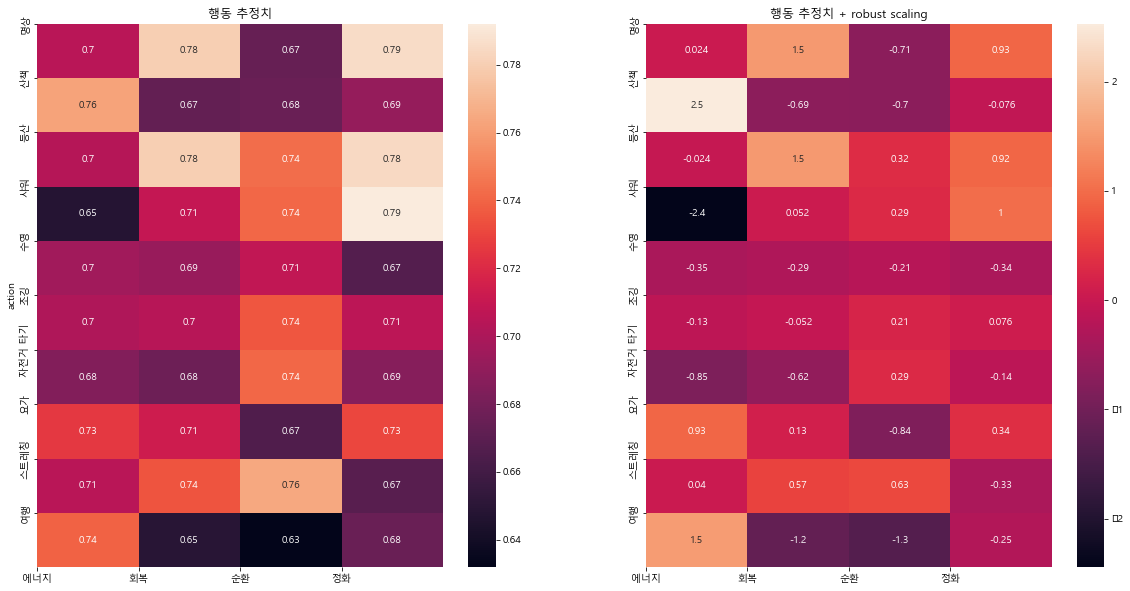

In [49]:
from sklearn.preprocessing import robust_scale

'''
rob_est = []
for idx in act_dim.index:
    act_est = np.array(act_dim.loc[idx]).reshape(-1,1)
    scaler = robust_scale(act_est)
    normal_act_est = np.array(scaler.tolist()).flatten()
    rob_est.append(normal_act_est)
'''

rob_est = []
for col in act_dim.columns:
    dim_ests = np.array(act_dim[col]).reshape(-1,1) 
    scaler = robust_scale(dim_ests)
    rob_dim_est = np.array(scaler.tolist()).flatten()
    rob_est.append(rob_dim_est)

rob_est = np.array(rob_est).T


plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(act_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(action_list)))
ax1.set_yticklabels(action_list)
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(rob_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + robust scaling')
ax2.set_yticks(np.arange(0,len(action_list)))
ax2.set_yticklabels(action_list)
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()